In [ ]:
!nvidia-smi

Tue Nov 24 12:42:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

V100, P100, V4, K80

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential,Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_val = X_train[40000:]
y_val = y_train[40000:]
X_train = X_train[:40000]
y_train = y_train[:40000]

169009152/169001437 [==============================] - 4s 0us/step


In [ ]:
x_train = applications.inception_resnet_v2.preprocess_input(X_train)
x_val = applications.inception_resnet_v2.preprocess_input(X_val)
x_test = applications.inception_resnet_v2.preprocess_input(X_test)

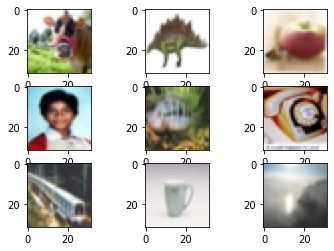

In [ ]:
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(X_train[i])
# show the figure
plt.show()

In [ ]:
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train)
y_val = onehot.transform(y_val)
y_test = onehot.transform(y_test)

In [ ]:
# initial hyper-parameter
batch_size = 32
num_classes = 100
epochs = 18
lrate = 1e-3
data_augmentation = True

##### Load a pretrained InceptionResNetV2 model without last FC layer (include_top=False) for Imagenet.

In [ ]:
resnet_model = applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
resnet_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 149, 149, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 149, 149, 32) 0           batch_normalization_203[0][0]    
________________________________________________________________________________

In [ ]:
model = Sequential([
        UpSampling2D(),
        UpSampling2D(),
        UpSampling2D(),
        resnet_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')                   
])

In [ ]:
opt = keras.optimizers.Adam(learning_rate=lrate)
model.compile(loss='categorical_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

In [ ]:
# link folder Save model to drive
!ln -s /content/drive/'My Drive'/CW1/Save_model /content/

In [ ]:
save_dir = 'Save_model/'
model_name = 'model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [ ]:
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)
callbacks = [checkpoint]

In [ ]:
if not data_augmentation:
    print('Not using Data Augmentation.')
    H = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val, y_val),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using Data Augmentation CutOut')
    # Data Augmentation
    # datagen = ImageDataGenerator(preprocessing_function=data_process(p=0.5))
    datagen.fit(x_train)              
    H = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                  steps_per_epoch=x_train.shape[0] // batch_size,
                  validation_data=(x_val, y_val),
                  epochs=epochs, verbose=1,
                  callbacks=callbacks)

Using Data Augmentation
Epoch 1/18
1250/1250 [==============================] - ETA: 0s - loss: 2.2498 - accuracy: 0.4448WARNING:tensorflow:Model was constructed with shape (None, 299, 299, 3) for input Tensor("input_2:0", shape=(None, 299, 299, 3), dtype=float32), but it was called on an input with incompatible shape (None, 256, 256, 3).

Epoch 00001: val_accuracy improved from -inf to 0.66040, saving model to Save_model/model.h5
1250/1250 [==============================] - 883s 706ms/step - loss: 2.2498 - accuracy: 0.4448 - val_loss: 1.1845 - val_accuracy: 0.6604
Epoch 2/18
1250/1250 [==============================] - ETA: 0s - loss: 1.3843 - accuracy: 0.6222
Epoch 00002: val_accuracy improved from 0.66040 to 0.72950, saving model to Save_model/model.h5
1250/1250 [==============================] - 880s 704ms/step - loss: 1.3843 - accuracy: 0.6222 - val_loss: 0.9284 - val_accuracy: 0.7295
Epoch 3/18
1250/1250 [==============================] - ETA: 0s - loss: 1.2000 - accuracy: 0.6610

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


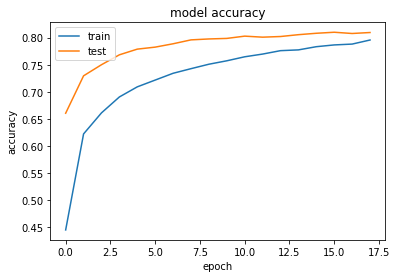

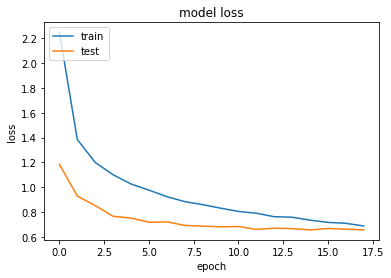

In [ ]:
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(x_test, y_test)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

313/313 [==============================] - 86s 276ms/step - loss: 0.6296 - accuracy: 0.8186
Test loss: 0.6296
Test accuracy: 0.8186


In [ ]:
model = load_model("Save_model/model.h5")
score = model.evaluate(x_test, y_test)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

313/313 [==============================] - 86s 276ms/step - loss: 0.6340 - accuracy: 0.8122
Test loss: 0.6340
Test accuracy: 0.8122


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_7 (UpSampling2 multiple                  0         
_________________________________________________________________
up_sampling2d_8 (UpSampling2 multiple                  0         
_________________________________________________________________
up_sampling2d_9 (UpSampling2 multiple                  0         
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_2 ( multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  786944    
_________________________________________________________________
dropout_2 (Dropout)          multiple                 

In [ ]:
!kill -9 -1